# Music Prediction Model
Last Update: 2021-08-21

Use the cleaned final dataset and build a model.

In [38]:
from lazypredict.Supervised import LazyRegressor
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import lightgbm as lgb
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt


In [39]:
#Import data
df = pd.read_csv('/Users/lcags/Documents/Practicum2/DATA/final_dataset.csv') #possibly go back to


In [40]:
#Get names of columns, removing year (for subsetting)
names = list(df.columns)
names.remove('year')

names

['weeks_on_chart',
 'peak_position',
 'spotify_track_duration_ms',
 'key',
 'loudness',
 'speechiness',
 'acousticness',
 'instrumentalness',
 'liveness',
 'valence',
 'tempo',
 'time_signature',
 'mode_False',
 'mode_True',
 'season_fall',
 'season_spring',
 'season_summer',
 'season_winter']

In [41]:
#x = independent variables
#y = dependent variable

x = np.array(df[names])
y = np.array(df[["year"]])


In [42]:
# 80/20 split, test/train

x_train, x_test, y_train, y_test = train_test_split(x,
                                                    y,
                                                    test_size= .2,
                                                    random_state = 0)


In [43]:
y_train.shape

(19135, 1)

In [44]:
y_test.shape

(4784, 1)

In [45]:
#Initialize LazyRegressor
lreg = LazyRegressor(verbose=0, ignore_warnings=True, custom_metric = None)

In [23]:
models,predictions = lreg.fit(x_train, x_test, y_train, y_test)
print(models)

100%|██████████| 42/42 [04:45<00:00,  6.81s/it]

                               Adjusted R-Squared  R-Squared    RMSE  \
Model                                                                  
LGBMRegressor                                0.77       0.77    9.09   
HistGradientBoostingRegressor                0.77       0.77    9.10   
XGBRegressor                                 0.77       0.77    9.14   
ExtraTreesRegressor                          0.75       0.75    9.49   
RandomForestRegressor                        0.75       0.75    9.55   
GradientBoostingRegressor                    0.74       0.74    9.72   
BaggingRegressor                             0.73       0.73    9.97   
SVR                                          0.65       0.65   11.22   
NuSVR                                        0.65       0.65   11.23   
KNeighborsRegressor                          0.62       0.62   11.73   
LinearRegression                             0.56       0.56   12.65   
TransformedTargetRegressor                   0.56       0.56   1

## Recreate chosen base model
LGBM Regression model

In [46]:
#Recreated base model
reg = lgb.LGBMRegressor(objective = 'Regression')
reg.fit(x_train, y_train)
y_pred_base = reg.predict(x_test)

mean_squared_error(y_test, y_pred_base,squared=False)

9.105663352451108

In [47]:
r2_score(y_test,y_pred_base)   

0.7725718232698707

In [48]:
mean_absolute_error(y_test,y_pred_base)

6.569416403597825

### Important Variables plotted

In [49]:
important = pd.DataFrame(reg.feature_importances_,names).sort_values(by=[0], ascending=True)

<AxesSubplot:>

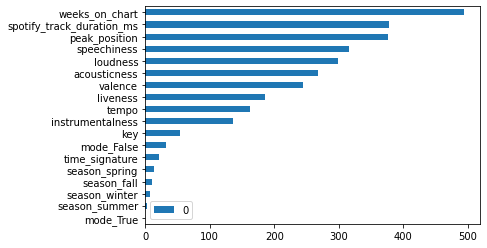

In [50]:
important.plot.barh()

### Tuning
Defaults for LGBM Regressor
* Learning Rate 0.1
* N_Estimators: 100
* Max_Depth: -1
* Num_Leaves: 31

In [51]:
param_grid = {
    'learning_rate': [0.01, 0.1, 1],
    'n_estimators': [100, 200,300],
    'max_depth': [-1,3,7],
    'num_leaves': [31,56,80],
}

In [28]:
gbm = GridSearchCV(reg, param_grid, cv=10)
gbm.fit(x_train, y_train)

GridSearchCV(cv=10, estimator=LGBMRegressor(objective='Regression'),
             param_grid={'learning_rate': [0.01, 0.1, 1],
                         'max_depth': [-1, 3, 7],
                         'n_estimators': [100, 200, 300],
                         'num_leaves': [31, 56, 80]})

In [29]:
gbm.best_params_

{'learning_rate': 0.1, 'max_depth': -1, 'n_estimators': 300, 'num_leaves': 56}

In [30]:
reg2 = lgb.LGBMRegressor(objective = 'Regression',
                        learning_rate = 0.1,
                        max_depth = -1,
                        n_estimators = 300,
                        num_leaves = 56,
)

reg2.fit(x_train, y_train)
y_pred = reg2.predict(x_test)

In [31]:
mean_squared_error(y_test, y_pred,squared=False)

9.009373838232019

In [32]:
r2_score(y_test,y_pred)   

0.7773563536398039

In [33]:
mean_absolute_error(y_test,y_pred)

6.441791249491499

# Exploring Predictions

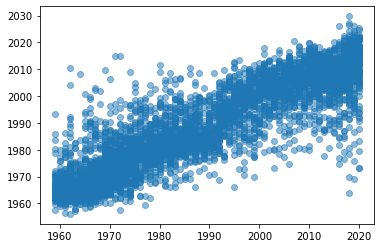

In [34]:
#Scatter plot between Actual vs Predicted
plt.scatter(y_test,y_pred,alpha=0.5)

In [36]:
residuals = y_test.flatten()-y_pred.flatten()

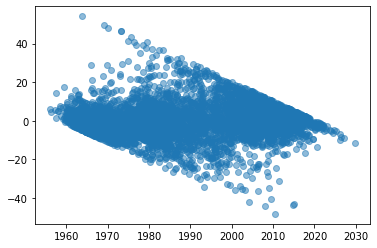

In [37]:
#Predicted vs Redisuals
plt.scatter(y_pred,residuals, alpha = 0.5)


In [52]:
#Explore Deltas
compare = pd.DataFrame({'Actual': y_test.flatten(),
                        'Predicted': y_pred.flatten(),
                        'Delta':abs(y_pred.flatten()-y_test.flatten())})

compare

,Actual,Predicted,Delta
0,1965,1975.33,10.33
1,1974,1983.97,9.97
2,1997,1999.33,2.33
3,2012,2002.23,9.77
4,1962,1966.09,4.09
...,...,...,...
4779,1980,1979.17,0.83
4780,1965,1965.68,0.68
4781,1981,1999.76,18.76
4782,1970,1975.02,5.02


<AxesSubplot:>

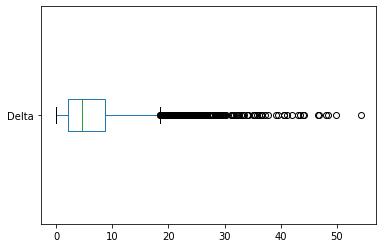

In [53]:
compare["Delta"].plot.box(vert = False)

The data has a lot of outliers on the higher end, implying when the prediction was wrong, it was **really** wrong.

<AxesSubplot:xlabel='Actual'>

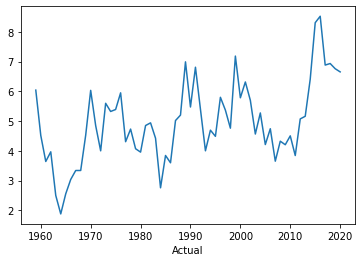

In [54]:
#Plot of deltas YoY
compare.groupby(["Actual"])["Delta"].median().plot(kind = "line")

Delta increases with time and spikes at the beginning of each decade. The highest point is the year that Glee was all over the charts with their covers. 

In [55]:
#Compare median values between actual and delta
compare.groupby(["Actual"])["Delta"].median()

Actual
1959   6.04
1960   4.52
1961   3.64
1962   3.97
1963   2.50
       ... 
2016   8.52
2017   6.88
2018   6.93
2019   6.76
2020   6.65
Name: Delta, Length: 62, dtype: float64

In [56]:
compare

,Actual,Predicted,Delta
0,1965,1975.33,10.33
1,1974,1983.97,9.97
2,1997,1999.33,2.33
3,2012,2002.23,9.77
4,1962,1966.09,4.09
...,...,...,...
4779,1980,1979.17,0.83
4780,1965,1965.68,0.68
4781,1981,1999.76,18.76
4782,1970,1975.02,5.02


In [57]:
#How many predictions were off by less than 3 years? 
np.where(compare['Delta']<=3, 1, 0).sum()

1640

(array([2.679e+03, 1.301e+03, 4.580e+02, 1.770e+02, 9.800e+01, 3.700e+01,
        1.700e+01, 9.000e+00, 6.000e+00, 2.000e+00]),
 array([1.15702906e-03, 5.42284252e+00, 1.08445280e+01, 1.62662135e+01,
        2.16878990e+01, 2.71095845e+01, 3.25312700e+01, 3.79529554e+01,
        4.33746409e+01, 4.87963264e+01, 5.42180119e+01]),
 <BarContainer object of 10 artists>)

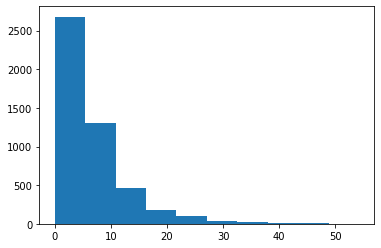

In [58]:
#View full histogram of deltas
plt.hist(compare['Delta'])

### References
* https://thecleverprogrammer.com/2021/06/19/lazy-predict-in-python-tutorial/
* https://www.analyticsvidhya.com/blog/2021/05/know-the-best-evaluation-metrics-for-your-regression-model/
* https://neptune.ai/blog/lightgbm-parameters-guide
* https://lightgbm.readthedocs.io/en/latest/Parameters-Tuning.html
* https://condor.depaul.edu/sjost/it223/documents/regress.htm